# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
import urllib.request
import matplotlib.pyplot as plt

plt.style.use('seaborn')
!pip install progressbar2
import time
import progressbar

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec(): #Ici on travaillait qu'avec des mots

    def __init__(self, filepath, vocab_size=50000): #vocabulaire de taille 50 k et embedding de taille 300
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        idx = self.word2id.get(word,"UNK") #si word pas dans le dictionnaire on renvoie UNK sinon on donne le mot
        if idx == "UNK": #va pas influer les autres vecteurs si on met 0
            return np.zeros(self.embeddings[0].shape)
        embedding = self.embeddings[self.word2id[word]]
        return embedding 
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        #raise NotImplementedError('Fill in the blank')
        similarity = np.dot(self.encode(word1),self.encode(word2))/(
        np.linalg.norm(self.encode(word1))*np.linalg.norm(self.encode(word2)))
        return similarity
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        #raise NotImplementedError('Fill in the blank')
        l = []
        w = np.array(self.words)
        for i in w:
            l.append(self.score(word,i))
        l = np.argsort(l)
        l = l[::-1]
        l = l[:5]
        return w[l]

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cat' 'cats' 'kitty' 'kitten' 'feline']
['dog' 'dogs' 'puppy' 'pup' 'canine']
['dogs' 'dog' 'cats' 'puppies' 'Dogs']
['Paris' 'France' 'Parisian' 'Marseille' 'Brussels']
['Germany' 'Austria' 'Europe' 'Berlin' 'Hamburg']


In [5]:
#ici on travaille non pas qu'avec des mots mais aussi avec des phrases donc on va utiliser BagOfWords
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dico = {}
        
    def remove_duplicate(self,sentence): 
        words = sentence.split()
        return " ".join(sorted(set(words),key=words.index))
        
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        #on fait idf de notre corpus de texte, c'est à dire sentences ici
        idf = {}
        D = len(sentences)
        for sentence in sentences: #on va compter le nombre de fois où le mot apparait dans le corpus
            sentence = self.remove_duplicate(sentence) #cette fonction nous permet d'enlever les doublons dans une phrase
            for word in sentence.split(): #pas besoin de split, np.unique le fait deja
                idf[word] = idf.get(word, 0) + 1 #on ajoute 1 dès qu'on renconte le nombre
        for key in idf.keys():
            idf[key] = np.log(D/idf[key])
        
        return idf
                
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding : on fait embedding de la phrase en prenant chaque mot et en faisant son embedding ou en faisait embedding weighté par BoW
        if idf is None:
            # mean of word vectors
            #on encode avec le word embedding et on fait le mean
            liste = []
            for word in sentence.split():#.split() pour itérer sur les mots et non pas les lettres
                liste.append(self.word2vec.encode(word))
            return np.mean(liste,axis = 0) #on a pas pris en compte les mots pas dans le voc mais c'est pas grave c'est comme si on mettait à 0
            
        else:
            # idf-weighted mean of word vectors
            #cette fois ci on fait pareille en weightant chaque embedding idf
            liste = []
            for word in sentence.split():
                liste.append(self.word2vec.encode(word)*idf[word])
            return np.mean(liste,axis = 0)
            

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        #raise NotImplementedError('Fill in the blank')
        similarity = np.dot(self.encode(sentence1,idf),self.encode(sentence2,idf))/(
        np.linalg.norm(self.encode(sentence1,idf))*np.linalg.norm(self.encode(sentence2,idf)))
        return similarity
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        #query = self.encode(sentence, idf)
        #keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        l = []
        sentences = np.array(sentences)
        for s in progressbar.progressbar(sentences):
            l.append(self.score(s,sentence,idf))
        l = np.argsort(l)
        l = l[::-1]
        l = l[:5]
        return sentences[l]

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors


N/A% (0 of 150736) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--


	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475


100% (150736 of 150736) |################| Elapsed Time: 0:00:21 Time:  0:00:21


1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 


N/A% (0 of 150736) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--


	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400799939346387


100% (150736 of 150736) |################| Elapsed Time: 0:00:32 Time:  0:00:32


2 female babies eating chips . 
1) 2 female babies eating chips . 
2) 2 kids holding hands and smiling . 
3) 2 chinese people wearing traditional clothes 
4) five children , 3 boys and 2 girls playing soccer in a grass field . 
5) 3 couples in white clothes are playing piggyback . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        
        liste = []
        for word in self.fr_word2vec.words:
            if word in self.en_word2vec.words:
                liste.append(word)
    
        self.X , self.Y = np.empty([300,len(liste)]),np.empty([300,len(liste)])
        for i,word in enumerate(liste):
            self.X[:,i] = self.fr_word2vec.encode(word)
            self.Y[:,i] = self.en_word2vec.encode(word)
        assert self.X.shape[0] == 300 and self.Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, S, Vh = np.linalg.svd(self.Y@self.X.T)
        W = U@Vh #une fois qu'on a la matrice W qu'on sait vrai car on la fait pour les mots similaire on pourra l'utiliser pour n'importe quel mot
        assert W.shape == (300, 300) 
        #le return va etre notre tranduction des mots francais à anglais 
        return np.matmul(self.fr_word2vec.embeddings, W.transpose()) #.embeddings nous ressort la matrice d'embedding de chaque mot
    
    def score(self,word1,word2):
        similarity = np.dot(word1,word2)/(
        np.linalg.norm(word1)*np.linalg.norm(word2))
        return similarity
        
    def get_closee(self,word_emb,k):
        liste = []
        for w in self.en_word2vec.words:
            liste.append(self.score(word_emb,self.en_word2vec.encode(w)))
        liste = np.argsort(liste)
        liste = liste[::-1][:k]
        return liste    
    
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        identifiant = self.fr_word2vec.word2id[fr_word] 
        #embedd represente l'embedding du mot francais en anglais
        embedd = self.aligned_fr_embeddings[identifiant] #on prend la ligne de notre mot c'est à dire la ligne qui correspond au bon mot dans WX 
        liste = self.get_closee(embedd,k)
        l = []
        for i in liste:
            l.append(self.en_word2vec.id2word[i])
        return l 
    
        
        
        
        

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE


def labelisation(X):
    x,y = [],[]
    for line in X:
        y.append(int(line[0]))
        x.append(line.strip("\n")[2:])
    return x,y

with open(train_filepath,"r") as file :
    X_train = file.readlines()
    
with open(dev_filepath,"r") as file :
    X_dev = file.readlines()
    

with open(test_filepath,"r") as file :
    X_test = []
    for line in file.readlines():
        X_test.append(line.strip("\n"))
        
    
    
X_train,Y_train = labelisation(X_train)
X_dev,Y_dev = labelisation(X_dev)

In [10]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000) #on fait embedding en anglais
sentence2vec = BagOfWords(word2vec)

train_liste, dev_liste,test_liste = [],[],[]
for sentence in X_train:
    train_liste.append(sentence2vec.encode(sentence))
for sentence in X_dev:
    dev_liste.append(sentence2vec.encode(sentence))
for sentence in X_test:
    test_liste.append(sentence2vec.encode(sentence))


train_liste_idf, dev_liste_idf,test_liste_idf = [],[],[]
idf = sentence2vec.build_idf(X_train+X_dev)
for sentence in X_train:
    train_liste_idf.append(sentence2vec.encode(sentence,idf=idf))
for sentence in X_dev:
    dev_liste_idf.append(sentence2vec.encode(sentence,idf=idf))
for sentence in X_dev:
    test_liste_idf.append(sentence2vec.encode(sentence,idf=idf))

Loaded 50000 pretrained word vectors


The score for BoW on train set is :  0.4624297752808989
The score for BoW with IDF on train set is :  0.43316947565543074
The score for BoW on dev set is :  0.4187102633969119
The score for BoW with IDF on dev set is :  0.40417801998183467


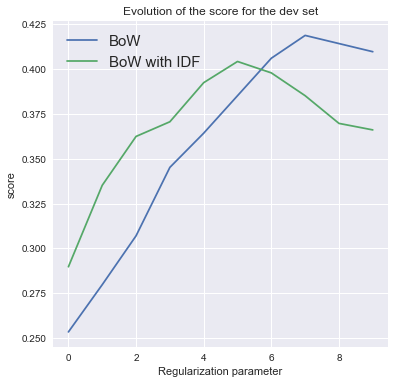

In [11]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
import warnings
warnings.filterwarnings('ignore')

X_train = np.array(train_liste)
Y_train = np.array(Y_train)
X_dev = np.array(dev_liste)
Y_dev = np.array(Y_dev)

X_train_idf = np.array(train_liste_idf)
Y_train_idf = np.array(Y_train)
X_dev_idf = np.array(dev_liste_idf)
Y_dev_idf = np.array(Y_dev)
from sklearn.linear_model import LogisticRegression


regs = np.logspace(-3,2,10)
liste ,liste_idf= [],[]
liste2 ,liste2_idf= [],[]
for pen in regs:
    clf = LogisticRegression(solver = 'lbfgs',multi_class = 'auto', C = pen,max_iter = 1000)
    clf.fit(X_train,Y_train)
    score = clf.score(X_dev, Y_dev)
    score2 = clf.score(X_train,Y_train)
    liste.append(score)
    liste2.append(score2)
    
    clf_idf = LogisticRegression(solver = 'lbfgs',multi_class = 'auto', C = pen)
    clf_idf.fit(X_train_idf,Y_train_idf)
    score_idf = clf.score(X_dev_idf, Y_dev_idf)
    score2_idf = clf.score(X_train_idf,Y_train_idf)
    liste_idf.append(score_idf)
    liste2_idf.append(score2_idf)
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(liste)
ax.plot(liste_idf)
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("score")
ax.set_title("Evolution of the score for the dev set")
ax.legend( ['BoW', 'BoW with IDF'], fontsize = 15)
    
print("The score for BoW on train set is : ",liste2[np.argsort(liste)[-1]])
print("The score for BoW with IDF on train set is : ",liste2_idf[np.argsort(liste_idf)[-1]])

print("The score for BoW on dev set is : ",liste[np.argsort(liste)[-1]])
print("The score for BoW with IDF on dev set is : ",liste_idf[np.argsort(liste_idf)[-1]])


In [12]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
#regs = np.logspace(-3,2,6)
#print(regs)
X_test = np.array(test_liste)
X_test_idf = np.array(test_liste_idf)
y_pred = clf.predict(X_test_idf)

with open("logreg_bow_y_test_sst.txt","w+") as f:
    for y in y_pred:
        f.write(str(y)+"\n")


For a RandomForest Classifier, the score for BoW on train set is :  0.39630149812734083
For a RandomForest Classifier, the score for BoW with IDF on train set is :  0.4012172284644195
For a RandomForest Classifier, the score for BoW on dev set is :  0.3405994550408719
For a RandomForest Classifier, the score for BoW with IDF on dev set is :  0.33969118982742963


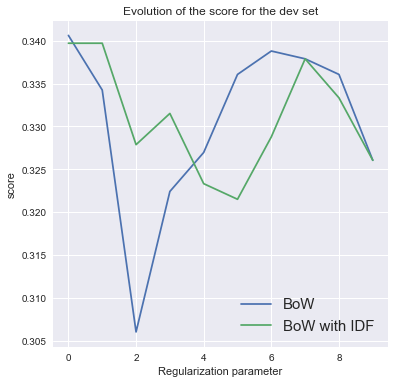

In [13]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X_train = np.array(train_liste)
Y_train = np.array(Y_train)
X_dev = np.array(dev_liste)
Y_dev = np.array(Y_dev)

X_train_idf = np.array(train_liste_idf)
Y_train_idf = np.array(Y_train)
X_dev_idf = np.array(dev_liste_idf)
Y_dev_idf = np.array(Y_dev)


regs = np.logspace(-3,2,10)
liste ,liste_idf= [],[]
liste2 ,liste2_idf= [],[]
for pen in regs:
    clf = RandomForestClassifier(max_depth=5)
    clf.fit(X_train, Y_train)
    score = clf.score(X_dev, Y_dev)
    score2 = clf.score(X_train, Y_train)
    liste.append(score)
    liste2.append(score2)
    
    clf = RandomForestClassifier(max_depth=5)
    clf.fit(X_train_idf, Y_train_idf)
    score_idf = clf.score(X_dev_idf, Y_dev_idf)
    score2_idf = clf.score(X_train_idf, Y_train_idf)
    liste_idf.append(score_idf)
    liste2_idf.append(score2_idf)
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(liste)
ax.plot(liste_idf)
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("score")
ax.set_title("Evolution of the score for the dev set")
ax.legend( ['BoW', 'BoW with IDF'], fontsize = 15)


print("For a RandomForest Classifier, the score for BoW on train set is : ",liste2[np.argsort(liste)[-1]])
print("For a RandomForest Classifier, the score for BoW with IDF on train set is : ",liste2_idf[np.argsort(liste_idf)[-1]])

print("For a RandomForest Classifier, the score for BoW on dev set is : ",liste[np.argsort(liste)[-1]])
print("For a RandomForest Classifier, the score for BoW with IDF on dev set is : ",liste_idf[np.argsort(liste_idf)[-1]])

X_test = np.array(test_liste)
X_test_idf = np.array(test_liste_idf)
y_pred = clf.predict(X_test_idf)

with open("XXX_bow_y_test_sst.txt","w+") as f:
    for y in y_pred:
        f.write(str(y)+"\n")


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [14]:
import tensorflow as tf

In [15]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE

def labelisation(X):
    x,y = [],[]
    for line in X:
        y.append(int(line[0]))
        x.append(line.strip("\n")[2:])
    return x,y

with open(train_filepath,"r") as file :
    X_train = file.readlines()
    
with open(dev_filepath,"r") as file :
    X_dev = file.readlines()
    

with open(test_filepath,"r") as file :
    X_test = []
    for line in file.readlines():
        X_test.append(line.strip("\n"))
        
    
    
X_train,Y_train = labelisation(X_train)
X_dev,Y_dev = labelisation(X_dev)

#First to tokenize we need to fit on a certain corpus, here our train, we put a size of 200k and add one token for OOV
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=200000, oov_token=200001) #we add a token for Out Of Vocabulary word
tokenizer.fit_on_texts(X_train)





#this is our embedding weigth that we are going to use for the question 5) INOVATE
word2vec = Word2Vec(en_embeddings_path, vocab_size = 200000)
dico = {}
for sentence in X_train + X_dev + X_test:
    for word in sentence.split():
        if word not in dico.keys():
            dico[word] = word2vec.encode(word)

weigth_dico = np.zeros((len(dico),300))
i = 0
for key,value in dico.items():
    weigth_dico[i] = value
    i+=1 
    
    


Loaded 200000 pretrained word vectors


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [16]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/


#Now for the train, we put our liste of sentence into a sequence, and then pass this sequence to the padding
train_seq = tokenizer.texts_to_sequences(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=35, padding='post', truncating='post')

dev_seq = tokenizer.texts_to_sequences(X_dev)
X_dev = tf.keras.preprocessing.sequence.pad_sequences(dev_seq, maxlen=35, padding='post', truncating='post')

test_seq = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=35, padding='post', truncating='post')

## 4.2 - Design and train your model

In [17]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5



model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))



In [18]:
# 4 - Define your loss/optimizer/metrics
from tensorflow.keras import losses
from keras import optimizers
# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 15,093,765
Trainable params: 15,093,765
Non-trainable params: 0
_________________________________________________________________
None


Using TensorFlow backend.




EMBEDDING SIZE :  30


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_122 (Embedding)    (None, None, 30)          1500000   
_________________________________________________________________
lstm_104 (LSTM)              (None, 64)                24320     
_________________________________________________________________
dense_116 (Dense)            (None, 5)                 325       
Total params: 1,524,645
Trainable params: 1,524,645
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/25
8544/8544 [==============================] - 26s 3ms/step - loss: 1.5767 - acc: 0.2662 - val_loss: 1.5754 - val_acc: 0.2534
Epoch 2/25
8544/8544 [==============================] - 4s 413us/step - loss: 1.5734 - acc: 0.2592 - val_loss: 1.5754 - val_acc: 0.2534
Epoch 3/25
8544/8544 [=========================

Epoch 23/25
8544/8544 [==============================] - 5s 625us/step - loss: 1.2493 - acc: 0.4460 - val_loss: 1.4003 - val_acc: 0.3806
Epoch 24/25
8544/8544 [==============================] - 5s 630us/step - loss: 1.2194 - acc: 0.4671 - val_loss: 1.4571 - val_acc: 0.3842
Epoch 25/25
8544/8544 [==============================] - 6s 647us/step - loss: 1.1876 - acc: 0.4730 - val_loss: 1.5275 - val_acc: 0.3697


EMBEDDING SIZE :  150


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_124 (Embedding)    (None, None, 150)         7500000   
_________________________________________________________________
lstm_106 (LSTM)              (None, 64)                55040     
_________________________________________________________________
dense_118 (Dense)            (None, 5)                 325       
Total params: 7,555,365
Trainable params: 7,555,365
Non-trainable params: 0
_________________________

8544/8544 [==============================] - 14s 2ms/step - loss: 1.1351 - acc: 0.4855 - val_loss: 1.3962 - val_acc: 0.3851
Epoch 21/25
8544/8544 [==============================] - 15s 2ms/step - loss: 1.1035 - acc: 0.4968 - val_loss: 1.4291 - val_acc: 0.3751
Epoch 22/25
8544/8544 [==============================] - 15s 2ms/step - loss: 1.0768 - acc: 0.5069 - val_loss: 1.4711 - val_acc: 0.3851
Epoch 23/25
8544/8544 [==============================] - 16s 2ms/step - loss: 1.0528 - acc: 0.5151 - val_loss: 1.4315 - val_acc: 0.3906
Epoch 24/25
8544/8544 [==============================] - 15s 2ms/step - loss: 1.0385 - acc: 0.5275 - val_loss: 1.5801 - val_acc: 0.3806
Epoch 25/25
8544/8544 [==============================] - 14s 2ms/step - loss: 1.0203 - acc: 0.5423 - val_loss: 1.4442 - val_acc: 0.3896


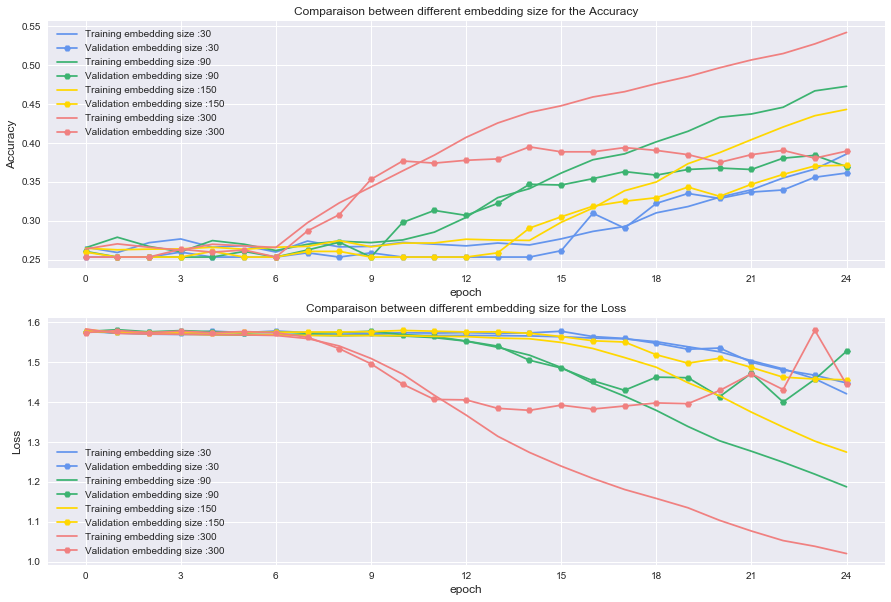

In [464]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_dev = to_categorical(Y_dev)
bs = 128
n_epochs = 5

embedd = [30,90,150,300]
liste = []
for embed_dim in embedd :
    print("\n")
    print("EMBEDDING SIZE : ", embed_dim)
    print("\n")
    
    
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim))
    model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(n_classes, activation='softmax'))
    
    loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
    optimizer        =  'rmsprop' # find the right optimizer
    metrics_classif  =  ['accuracy']


    model.compile(loss=loss_classif,
                  optimizer=optimizer,
                  metrics=metrics_classif)
    print(model.summary())
    
    

    bs = 128
    n_epochs = 25
    history = model.fit(X_train, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, Y_dev))
    liste.append(history)
    
    
#we plot 

from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(211)
colors = ["cornflowerblue","mediumseagreen","gold","lightcoral"]
for nb, name in enumerate(embedd):
    ax.plot(range(25),liste[nb].history['acc'],color = colors[nb] ,label = "Training embedding size :" + str(name))
    ax.plot(range(25),liste[nb].history['val_acc'],"H-",color = colors[nb],label = "Validation embedding size :" + str(name))


ax.set_xlabel("epoch",fontsize = 12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
ax.set_ylabel("Accuracy",fontsize = 12)
ax.set_title("Comparaison between different embedding size for the Accuracy",fontsize=12)
ax.legend()



ax = fig.add_subplot(212)

for nb, name in enumerate(embedd):
    ax.plot(range(25),liste[nb].history['loss'],color = colors[nb],label = "Training embedding size :" + str(name))
    ax.plot(range(25),liste[nb].history['val_loss'],"H-",color = colors[nb],label = "Validation embedding size :" + str(name))


ax.set_xlabel("epoch",fontsize = 12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Loss",fontsize = 12)
ax.set_title("Comparaison between different embedding size for the Loss",fontsize=12)
ax.legend()

In [465]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

with open("logreg_lstm_y_test_sst.txt","w+") as file:
    val = np.argmax(model.predict(X_test),axis = 1)
    for i in val:
        file.write(str(i)+"\n")


## 4.3 - innovate !

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         5860800   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 50)          30050     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, None, 50)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 50)          7550      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, None, 50)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               183296    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
Total para

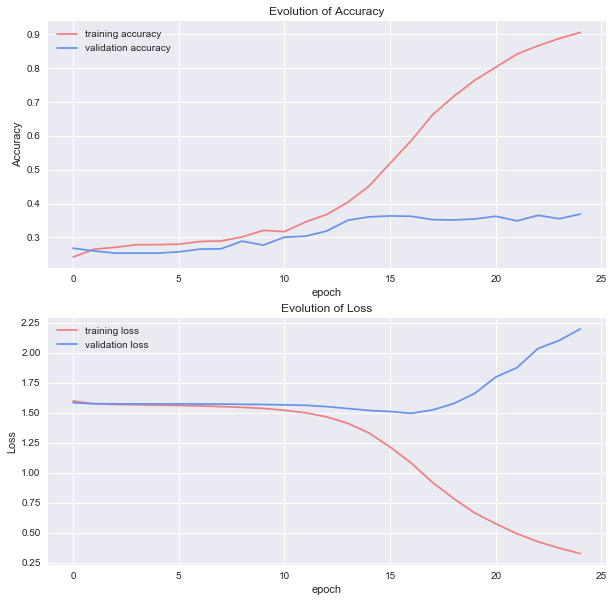

In [28]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.


#This is INITIALIZATION (just a copy of question 4.1 and 4.2)

train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'
def labelisation(X):
    x,y = [],[]
    for line in X:
        y.append(int(line[0]))
        x.append(line.strip("\n")[2:])
    return x,y
with open(train_filepath,"r") as file :
    X_train = file.readlines()
with open(dev_filepath,"r") as file :
    X_dev = file.readlines()
with open(test_filepath,"r") as file :
    X_test = []
    for line in file.readlines():
        X_test.append(line.strip("\n"))
X_train,Y_train = labelisation(X_train)
X_dev,Y_dev = labelisation(X_dev)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=200000, oov_token=200001)
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=35, padding='post', truncating='post')
dev_seq = tokenizer.texts_to_sequences(X_dev)
X_dev = tf.keras.preprocessing.sequence.pad_sequences(dev_seq, maxlen=35, padding='post', truncating='post')
test_seq = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=35, padding='post', truncating='post')

#### END OF INITIALIZATION



from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D, Dropout, Bidirectional


Y_train = to_categorical(Y_train)
Y_dev = to_categorical(Y_dev)
n_classes = 5
vocab_size = weigth_dico.shape[0]
nhid = 128
n_epochs = 25
embed_dim = 300
bs = 128

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,trainable = True, weights = [weigth_dico]))
model.add(Conv1D(filters = 50,kernel_size = 2,padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 5))
model.add(Conv1D(filters = 50,kernel_size = 3,padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 5))
model.add(Bidirectional(LSTM(nhid, dropout=0.5)))
model.add(Dense(n_classes, activation='softmax'))
model.summary()



loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
#optimizer        =  'adam'# find the right optimizer
metrics_classif  =  ['accuracy']
optimizer  = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-06)

model.compile(loss=loss_classif,
                optimizer=optimizer,
                metrics=metrics_classif)
history = model.fit(X_train, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, Y_dev))


#we create the file for the test
with open("XXX_XXX_y_test_sst.txt","w+") as file:
    val = np.argmax(model.predict(X_test),axis = 1)
    for i in val:
        file.write(str(i)+"\n")
        
        
#plot
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(211)

ax.plot(range(25),history.history['acc'],label = "training accuracy", color = "lightcoral")
ax.plot(range(25),history.history['val_acc'],label = "validation accuracy", color = "cornflowerblue")
ax.set_xlabel('epoch')
ax.set_ylabel('Accuracy')
ax.set_title("Evolution of Accuracy")
ax.legend()

ax = fig.add_subplot(212)
ax.plot(range(25),history.history['loss'],label = "training loss", color = "lightcoral")
ax.plot(range(25),history.history['val_loss'],label = "validation loss", color = "cornflowerblue")
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.set_title("Evolution of Loss")
ax.legend()